In [ ]:
pip install pyspark

In [ ]:
# Importation des bibliothèques
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
#. Initialiser Spark Session
spark = SparkSession.builder \
    .appName("Analyse des maladies cardiaques") \
    .getOrCreate()

In [ ]:
# 1. Collecte de Données
# Charger le fichier CSV (le fichier uploadé dans Colab)
file_path = "/content/heart.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)
# Aperçu des données
data.show(5)
data.printSchema()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|
| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|
| 61|  1|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|
| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
only showing top 5 rows

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable =

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Définir les colonnes catégorielles
categorical_columns = ['sex', 'target']

# Étape 1 : Indexation des colonnes catégorielles
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]

# Étape 2 : Encodage One-Hot
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_ohe") for col in categorical_columns]

# Créer et exécuter le pipeline
pipeline = Pipeline(stages=indexers + encoders)
data = pipeline.fit(data).transform(data)

# Afficher les résultats
data.select("sex", "sex_index", "sex_ohe", "target", "target_index", "target_ohe").show(5)


+---+---------+-------------+------+------------+----------+
|sex|sex_index|      sex_ohe|target|target_index|target_ohe|
+---+---------+-------------+------+------------+----------+
|  1|      0.0|(1,[0],[1.0])|     0|         1.0| (1,[],[])|
|  1|      0.0|(1,[0],[1.0])|     0|         1.0| (1,[],[])|
|  1|      0.0|(1,[0],[1.0])|     0|         1.0| (1,[],[])|
|  1|      0.0|(1,[0],[1.0])|     0|         1.0| (1,[],[])|
|  0|      1.0|    (1,[],[])|     0|         1.0| (1,[],[])|
+---+---------+-------------+------+------------+----------+
only showing top 5 rows



In [ ]:
# 2. Préparation des Données
# a) Gérer les valeurs manquantes
data = data.na.fill(0)  # Remplacer les valeurs nulles par 0

# b) Supprimer les doublons
data = data.dropDuplicates()

# c) Renommer les colonnes pour une meilleure lisibilité
for col_name in data.columns:
    data = data.withColumnRenamed(col_name, col_name.lower())

# Valider les changements
data.show(5)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+---------+------------+-------------+-------------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|sex_index|target_index|      sex_ohe|   target_ohe|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+---------+------------+-------------+-------------+
| 63|  0|  2|     135| 252|  0|      0|    172|    0|    0.0|    2|  0|   2|     1|      1.0|         0.0|    (1,[],[])|(1,[0],[1.0])|
| 54|  1|  0|     110| 239|  0|      1|    126|    1|    2.8|    1|  1|   3|     0|      0.0|         1.0|(1,[0],[1.0])|    (1,[],[])|
| 47|  1|  0|     110| 275|  0|      0|    118|    1|    1.0|    1|  1|   2|     0|      0.0|         1.0|(1,[0],[1.0])|    (1,[],[])|
| 45|  0|  1|     130| 234|  0|      0|    175|    0|    0.6|    1|  0|   2|     1|      1.0|         0.0|    (1,[],[])|(1,[0],[1.0])|
| 51|  1|  2|     100| 222|  0|      1|    143|    1|  

In [ ]:
# 3. Stockage des Données
# Sauvegarder les données nettoyées dans un fichier Parquet
data.write.parquet("cleaned_data.parquet", mode="overwrite")

+------+-----+
|target|count|
+------+-----+
|     1|  164|
|     0|  138|
+------+-----+



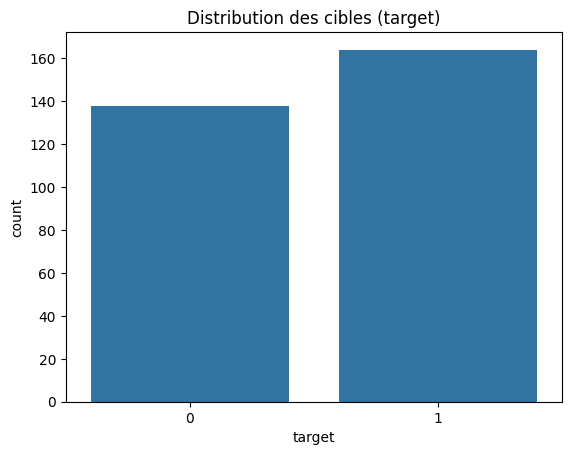

In [ ]:
# 4. Analyse Exploratoire des Données (EDA)
# a) Utiliser Spark SQL
# Créer une vue temporaire pour exécuter des requêtes SQL
data.createOrReplaceTempView("heart_data")

# Exemple : compter les entrées par groupe "target"
target_count = spark.sql("SELECT target, COUNT(*) as count FROM heart_data GROUP BY target")
target_count.show()

# b) Visualisation avec Matplotlib et Seaborn
# Convertir les données Spark en Pandas pour la visualisation
pandas_df = target_count.toPandas()

# Visualisation
sns.barplot(data=pandas_df, x="target", y="count")
plt.title("Distribution des cibles (target)")
plt.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# a) Préparation des données
feature_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']  # Exemples de colonnes utilisées
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Assurez-vous que la colonne 'target' (ou autre colonne de label) existe
data = data.withColumn("label", col("target").cast("double"))

# b) Division des données en train et test
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

# c) Modélisation avec Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=20)
model = rf.fit(train_data)

# d) Prédiction sur les données de test
predictions = model.transform(test_data)
predictions = model.transform(test_data)

# e) Évaluation du modèle
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Affichage des résultats
print(f"Accuracy: {accuracy:.2f}")
predictions.select("age", "trestbps", "chol", "thalach", "oldpeak", "prediction").show(5)


Accuracy: 0.70
+---+--------+----+-------+-------+----------+
|age|trestbps|chol|thalach|oldpeak|prediction|
+---+--------+----+-------+-------+----------+
| 34|     118| 182|    174|    0.0|       1.0|
| 35|     122| 192|    174|    0.0|       1.0|
| 37|     130| 250|    187|    3.5|       0.0|
| 39|     118| 219|    140|    1.2|       0.0|
| 41|     126| 306|    163|    0.0|       1.0|
+---+--------+----+-------+-------+----------+
only showing top 5 rows



<ipython-input-20-95e8700d4e6c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pred_pandas, x="prediction", y="chol", palette="viridis")


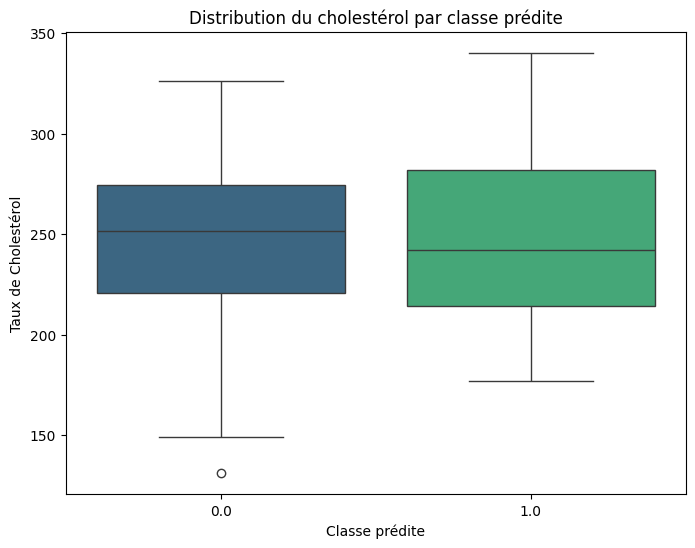

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir les prédictions Spark en DataFrame Pandas
pred_pandas = predictions.select("age", "chol", "prediction").toPandas()

# Création du Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=pred_pandas, x="prediction", y="chol", palette="viridis")

# Personnalisation du graphique
plt.title("Distribution du cholestérol par classe prédite")
plt.xlabel("Classe prédite")
plt.ylabel("Taux de Cholestérol")


plt.show()


**Création d'un Scatter Plot (Nuage de points)**

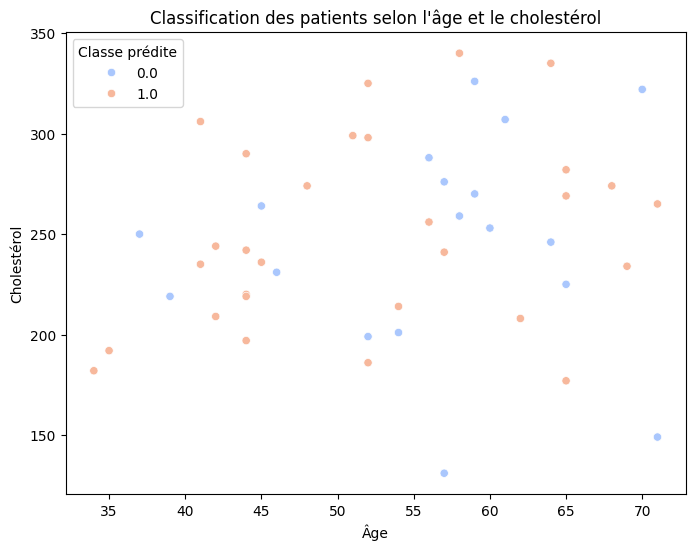

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pred_pandas, x="age", y="chol", hue="prediction", palette="coolwarm")

# Personnalisation du graphique
plt.title("Classification des patients selon l'âge et le cholestérol")
plt.xlabel("Âge")
plt.ylabel("Cholestérol")
plt.legend(title="Classe prédite")

# Affichage du graphique
plt.show()